In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score,recall_score,precision_score,make_scorer
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.neural_network import MLPClassifier  # For ANN
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D

In [ ]:
toddlers_data = pd.read_csv("/content/drive/MyDrive/ASD/csv_result-Autism-Child-Data.csv")

In [ ]:
print(f'Shape of dataframe is: {toddlers_data.shape}')

Shape of dataframe is: (292, 22)


In [ ]:
toddlers_data

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,NO
3,4,0,1,0,0,1,1,0,0,0,...,f,?,yes,no,Jordan,no,4,4-11 years,?,NO
4,5,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,288,1,1,1,1,1,1,1,1,1,...,f,White-European,yes,yes,United Kingdom,no,10,4-11 years,Parent,YES
288,289,1,0,0,0,1,0,1,0,0,...,f,White-European,yes,yes,Australia,no,4,4-11 years,Parent,NO
289,290,1,0,1,1,1,1,1,0,0,...,m,Latino,no,no,Brazil,no,7,4-11 years,Parent,YES
290,291,1,1,1,0,1,1,1,1,1,...,m,South Asian,no,no,India,no,9,4-11 years,Parent,YES


In [ ]:
toddlers_data.isna().sum()

,0
id,0
A1_Score,0
A2_Score,0
A3_Score,0
A4_Score,0
A5_Score,0
A6_Score,0
A7_Score,0
A8_Score,0
A9_Score,0


In [ ]:
toddlers_data['age'] = toddlers_data['age'].replace('?', np.nan)
toddlers_data['ethnicity'] = toddlers_data['ethnicity'].replace('?', np.nan)
toddlers_data['relation'] = toddlers_data['relation'].replace('?', np.nan)

for column in ['age', 'ethnicity', 'relation']:
  most_frequent_value = toddlers_data[column].mode()[0]
  toddlers_data[column] = toddlers_data[column].fillna(most_frequent_value)


In [ ]:
pd.DataFrame(toddlers_data.isnull().sum(), columns=["Missing Values"]).style.bar(color = "#84A9AC")

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Missing Values
id,0
A1_Score,0
A2_Score,0
A3_Score,0
A4_Score,0
A5_Score,0
A6_Score,0
A7_Score,0
A8_Score,0
A9_Score,0


In [ ]:
def add_noise(data, noise_factor=0.01):
    noisy_data = data.copy()
    for col in data.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_factor, size=data[col].shape)
        noisy_data[col] += noise
    return noisy_data

# Apply random noise augmentation to A1-A10 columns
noisy_data = add_noise(toddlers_data)

# Concatenate the original and noisy data to create an augmented dataset
augmented_data = pd.concat([toddlers_data, noisy_data])

In [ ]:
# Sample a fraction of the original data (e.g., 50%) for duplication
duplicated_data = toddlers_data.sample(frac=0.5, replace=True)

# Randomly shuffle values within certain columns (e.g., 'ethnicity', 'relation')
duplicated_data['ethnicity'] = np.random.permutation(duplicated_data['ethnicity'])
duplicated_data['relation'] = np.random.permutation(duplicated_data['relation'])

# Concatenate the original and modified data
augmented_data = pd.concat([toddlers_data, duplicated_data])

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM on your numeric features (A1-A10)
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(toddlers_data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']])

# Generate new synthetic samples (e.g., 100 new rows)
synthetic_data = gmm.sample(n_samples=100)[0]

# Convert to dataframe and concatenate with the original data
synthetic_data_df = pd.DataFrame(synthetic_data, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10'])
augmented_data = pd.concat([toddlers_data, synthetic_data_df])

In [ ]:
def jitter_data(data, jitter_factor=0.01):
    jittered_data = data.copy()
    for col in data.select_dtypes(include=[np.number]).columns:
        jitter = np.random.uniform(-jitter_factor, jitter_factor, size=data[col].shape)
        jittered_data[col] += jitter
    return jittered_data

# Apply jittering augmentation
jittered_data = jitter_data(toddlers_data)
augmented_data = pd.concat([toddlers_data, jittered_data])

In [ ]:
augmented_data.shape

(584, 22)

In [ ]:
augmented_data.drop(['age_desc'], axis = 1, inplace = True)

In [ ]:
augmented_data= augmented_data.drop(columns=['result'])

In [ ]:
X = augmented_data.drop(['Class/ASD', 'relation'], axis=1)
y = augmented_data['Class/ASD']

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode target and features
le=LabelEncoder()
y = le.fit_transform(y)
X['gender'] = le.fit_transform(X['gender'])
X['jundice'] = le.fit_transform(X['jundice'])
X['austim'] = le.fit_transform(X['austim'])
X['contry_of_res'] = le.fit_transform(X['contry_of_res'])
X['ethnicity'] = le.fit_transform(X['ethnicity'])
#X['result'] = le.fit_transform(X['result'])
X['used_app_before'] = le.fit_transform(X['used_app_before'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
scaler = MinMaxScaler()
X[['age']] = scaler.fit_transform(X[['age']])
X

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before
0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.285714,1,5,0,0,24,0
1,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.285714,1,4,0,0,24,0
2,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.285714,1,9,0,0,24,1
3,4.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.142857,0,9,1,0,24,0
4,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.142857,1,5,1,0,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,288.000669,1.007618,1.009546,0.990754,0.993508,0.997303,1.002984,1.000305,1.000624,0.995527,0.996619,0.428571,0,9,1,1,50,0
288,289.005818,1.007777,-0.001944,0.003226,-0.008275,1.006648,0.006562,0.990970,0.004911,0.006633,0.990209,0.428571,0,9,1,1,3,0
289,290.005012,1.002443,-0.006121,1.000300,0.998185,0.999458,1.003712,1.003455,0.008491,0.008730,1.009427,0.000000,1,3,0,0,8,0
290,290.999473,1.009660,1.006205,1.001877,0.002348,0.999524,0.997772,1.000717,1.004193,0.990866,1.008216,0.000000,1,7,0,0,18,0


In [ ]:
print('------------Training Set------------------')
print(X_train.shape)
print(y_train.shape)

print('------------Test Set------------------')
print(X_test.shape)
print(y_test.shape)

------------Training Set------------------
(500, 18)
(500,)
------------Test Set------------------
(117, 18)
(117,)


In [ ]:

def train_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matrix=confusion_matrix(y_test,y_pred)
    print("Confusion Matrix is: ")
    print(matrix)
    print("\n\nScore Table is: ")
    score_df = pd.DataFrame([[accuracy, precision, recall, f1]],
                            columns=["accuracy", "precision", "recall", "f1"])

    return score_df

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
result=train_model(model,X_train, y_train, X_test, y_test)
result.index=["Logistic Regression"]
result

Confusion Matrix is: 
[[51  1]
 [ 5 60]]


Score Table is: 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1
Logistic Regression,0.948718,0.983607,0.923077,0.952381


In [ ]:
from sklearn.svm import SVC
model = SVC()
svm = train_model(model, X_train, y_train, X_test, y_test)
svm.index = ["SVM Classifier"]
result = pd.concat([result, svm])
result

Confusion Matrix is: 
[[25 27]
 [22 43]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037


In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
rfc = train_model(model, X_train, y_train, X_test, y_test)
rfc.index = ["Random Forest Classifier"]
result = pd.concat([result, rfc])
result

Confusion Matrix is: 
[[49  3]
 [ 1 64]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037
Random Forest Classifier,0.965812,0.955224,0.984615,0.969697


In [ ]:
from xgboost import XGBClassifier
import pandas as pd # Make sure pandas is imported

# Convert 'age' column to numeric before training
X_train['age'] = pd.to_numeric(X_train['age'])
X_test['age'] = pd.to_numeric(X_test['age']) # Apply to X_test as well for prediction


model = XGBClassifier()
xg = train_model(model, X_train, y_train, X_test, y_test)
xg.index = ["XGBoost Classifier"]
result = pd.concat([result, xg])
result

Confusion Matrix is: 
[[50  2]
 [ 1 64]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037
Random Forest Classifier,0.965812,0.955224,0.984615,0.969697
XGBoost Classifier,0.974359,0.969697,0.984615,0.977099


In [ ]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
gb = train_model(model, X_train, y_train, X_test, y_test)
gb.index = ["Gradient Boosting Classifier"]
result = pd.concat([result, gb])
result

Confusion Matrix is: 
[[49  3]
 [ 0 65]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037
Random Forest Classifier,0.965812,0.955224,0.984615,0.969697
XGBoost Classifier,0.974359,0.969697,0.984615,0.977099
Gradient Boosting Classifier,0.974359,0.955882,1.000000,0.977444


In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
dt = train_model(model, X_train, y_train, X_test, y_test)
dt.index = ["Decision Tree Classifier"]
result = pd.concat([result, dt])
result

Confusion Matrix is: 
[[45  7]
 [ 3 62]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037
Random Forest Classifier,0.965812,0.955224,0.984615,0.969697
XGBoost Classifier,0.974359,0.969697,0.984615,0.977099
Gradient Boosting Classifier,0.974359,0.955882,1.000000,0.977444
Decision Tree Classifier,0.914530,0.898551,0.953846,0.925373


In [ ]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
adb = train_model(model, X_train, y_train, X_test, y_test)
adb.index = ["Ada Boost Classifier"]
result = pd.concat([result, adb])
result

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix is: 
[[52  0]
 [ 0 65]]


Score Table is: 


,accuracy,precision,recall,f1
Logistic Regression,0.914530,0.950820,0.892308,0.920635
SVM Classifier,0.581197,0.614286,0.661538,0.637037
Random Forest Classifier,0.965812,0.955224,0.984615,0.969697
XGBoost Classifier,0.974359,0.969697,0.984615,0.977099
Gradient Boosting Classifier,0.974359,0.955882,1.000000,0.977444
Decision Tree Classifier,0.914530,0.898551,0.953846,0.925373
Ada Boost Classifier,1.000000,1.000000,1.000000,1.000000


#ANN+Random Forest

In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
# Best Random Forest Model
best_rf = rf_grid.best_estimator_
rf_train_predictions = best_rf.predict_proba(X_train)[:, 1].reshape(-1, 1)
rf_test_predictions = best_rf.predict_proba(X_test)[:, 1].reshape(-1, 1)

In [ ]:
# Step 2: Concatenate RF predictions with original features
X_train_hybrid = np.concatenate((X_train, rf_train_predictions), axis=1)
X_test_hybrid = np.concatenate((X_test, rf_test_predictions), axis=1)

In [ ]:
# Step 3: Optimize ANN Model
ann_params = {
    'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300, 500]
}
ann_grid = GridSearchCV(MLPClassifier(random_state=42), ann_params, cv=5, scoring='accuracy')
ann_grid.fit(X_train_hybrid, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42),
             param_grid={'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                         'learning_rate_init': [0.001, 0.01],
                         'max_iter': [300, 500]},
             scoring='accuracy')

In [ ]:
# Best ANN Model
best_ann = ann_grid.best_estimator_

In [ ]:
# Step 4: Weighted Blending of RF and ANN predictions
rf_blend_weight = 0.5  # You can adjust this weight as needed

In [ ]:
# Train and test predictions
rf_test_proba = best_rf.predict_proba(X_test)[:, 1]
ann_test_proba = best_ann.predict_proba(X_test_hybrid)[:, 1]

In [ ]:
# Weighted average of both predictions
final_predictions = (rf_blend_weight * rf_test_proba + (1 - rf_blend_weight) * ann_test_proba) >= 0.5

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,  final_predictions)
    precision = precision_score(y_test,  final_predictions)
    recall = recall_score(y_test, final_predictions)
    f1 = f1_score(y_test, final_predictions)
    matrix = confusion_matrix(y_test,  final_predictions)

    print("Confusion Matrix is: ")
    print(matrix)
    print("\n\nScore Table is: ")
    score_df = pd.DataFrame([[accuracy, precision, recall, f1]],
                            columns=["accuracy", "precision", "recall", "f1"])

    return score_df

# Using train_model to evaluate Random Forest + ANN Hybrid Model
result = train_model(best_ann, X_train_hybrid, y_train, X_test_hybrid, y_test)
result.index = ["Random Forest + ANN Hybrid Model"]
print(result)

Confusion Matrix is: 
[[50  2]
 [ 4 61]]


Score Table is: 
                                  accuracy  precision    recall        f1
Random Forest + ANN Hybrid Model  0.948718   0.968254  0.938462  0.953125


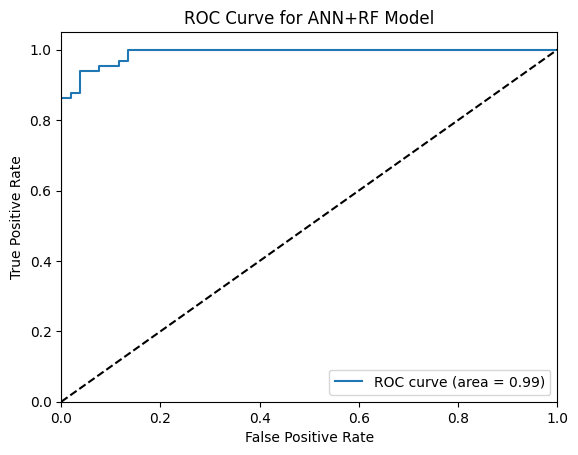

In [ ]:
# prompt: Roc curve for this ann+rf model with model name init

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'best_ann' and 'X_test_hybrid' are defined from the previous code
y_pred_proba = best_ann.predict_proba(X_test_hybrid)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN+RF Model') # Updated title
plt.legend(loc="lower right")
plt.show()

# XGBoost + Logistic Regression

In [ ]:
# Initialize individual models
xgb_model = XGBClassifier(random_state=42)
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Create the stacking ensemble
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('log_reg', log_reg_model)
    ],
    final_estimator=LogisticRegression(),  # Logistic Regression as the meta-learner
    cv=5  # Cross-validation for stability
)

In [ ]:
# Assuming 'X_train' is your DataFrame
X_train['age'] = pd.to_numeric(X_train['age'], errors='coerce')
# Instead of directly casting to Int64, round to the nearest integer and then cast:
X_train['age'] = X_train['age'].fillna(0).round().astype('Int64')

# Similarly, apply the transformation to X_test:
X_test['age'] = pd.to_numeric(X_test['age'], errors='coerce')
X_test['age'] = X_test['age'].fillna(0).round().astype('Int64')

# Now, proceed with training your stacked model:
result = train_model(stacked_model, X_train, y_train, X_test, y_test)
result.index = ["XGBoost + Logistic Regression Hybrid Model"]
print(result)

Confusion Matrix is: 
[[50  2]
 [ 4 61]]


Score Table is: 
                                            accuracy  precision    recall  \
XGBoost + Logistic Regression Hybrid Model  0.948718   0.968254  0.938462   

                                                  f1  
XGBoost + Logistic Regression Hybrid Model  0.953125  


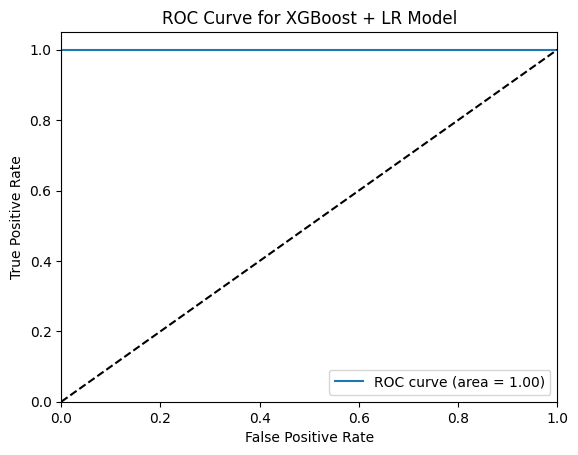

In [ ]:
# prompt: roc curve model for this xgboost+lr model with model name in it

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'stacked_model' and 'X_test' are defined from the previous code
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost + LR Model') # Updated title
plt.legend(loc="lower right")
plt.show()

#3. Autoencoder (ANN) + K-Nearest Neighbors (KNN):

In [ ]:
# Enhanced Autoencoder
encoding_dim = 16
autoencoder = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(encoding_dim, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(X_train.shape[1], activation='sigmoid')
])

In [ ]:
# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Step 2: Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1746.4691 - val_loss: 1603.0992
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1647.4645 - val_loss: 1600.4446
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1606.8110 - val_loss: 1597.8728
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1675.2256 - val_loss: 1596.4701
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1720.5691 - val_loss: 1595.9335
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1632.5532 - val_loss: 1595.7142
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1665.6250 - val_loss: 1595.6125
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1743.7554 - val_loss: 1595.5627
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1564.5101 - val_loss: 1595.5347
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1665.3027 - val_loss: 1595.5162
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1621.4622 - val_loss: 1595.5034
Epoch 1

In [ ]:
# Step 3: Extract the encoder part
encoder = Sequential([autoencoder.layers[0], autoencoder.layers[1], autoencoder.layers[2]])
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Step 4: Scale encoded features for KNN
scaler = MinMaxScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

In [ ]:
# Step 5: Train and evaluate KNN on encoded features
knn = KNeighborsClassifier(n_neighbors=5)  # you can adjust n_neighbors if needed
knn.fit(X_train_encoded, y_train)
y_pred = knn.predict(X_test_encoded)

In [ ]:
# Fine-tuning KNN with GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_encoded, y_train)
best_knn = grid.best_estimator_

In [ ]:
# Step 6: Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Modify step 6 to use the fine-tuned KNN model
y_pred = best_knn.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy:", accuracy)

Confusion Matrix:
 [[49  3]
 [61  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.94      0.60        52
           1       0.57      0.06      0.11        65

    accuracy                           0.45       117
   macro avg       0.51      0.50      0.36       117
weighted avg       0.52      0.45      0.33       117


Accuracy: 0.452991452991453


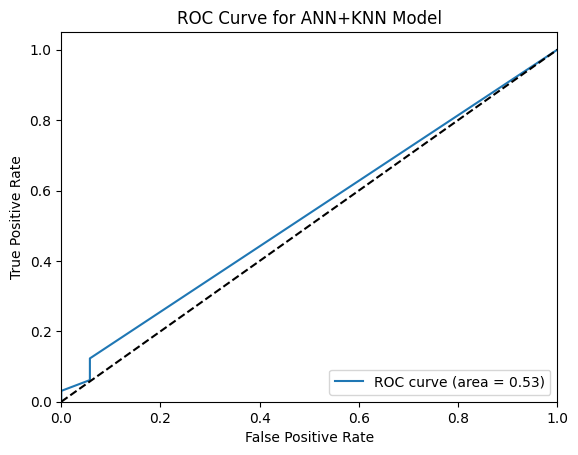

In [ ]:
# prompt: roc curve for ann+knn model with model name

from sklearn.metrics import roc_curve, auc

# Assuming 'best_knn' and 'X_test_encoded' are defined from the previous code
y_pred_proba = best_knn.predict_proba(X_test_encoded)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN+KNN Model')
plt.legend(loc="lower right")
plt.show()

# Stacked Model (Random Forest + XGBoost + ANN)

In [ ]:
# Base Models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

In [ ]:
# Stack Model Predictions (5-fold cross-validation on training set)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds)
meta_features_train = np.zeros((X_train.shape[0], 2))  # Store predictions from RF and XGBoost for each fold

for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Training Fold {i+1}/{n_folds}")

  # Train Random Forest and XGBoost on each fold and store predictions
    # Use .iloc to select rows using integer indices
    rf.fit(X_train.iloc[train_idx], y_train[train_idx])
    xgb.fit(X_train.iloc[train_idx], y_train[train_idx])

    # Generate predictions and store them as meta features
    # Use .iloc to select rows for predictions as well
    meta_features_train[val_idx, 0] = rf.predict(X_train.iloc[val_idx])
    meta_features_train[val_idx, 1] = xgb.predict(X_train.iloc[val_idx])

# Train the meta-model (ANN) on the combined base model predictions
meta_model = Sequential([
    Input(shape=(2,)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

Training Fold 1/5
Training Fold 2/5
Training Fold 3/5
Training Fold 4/5
Training Fold 5/5


In [ ]:
# Compile and train the ANN as the meta-model
meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
meta_model.fit(meta_features_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1866 - loss: 0.7168
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6801 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9389 - loss: 0.6452 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9442 - loss: 0.6108 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - loss: 0.5730 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.5361 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.4935 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.4584 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9380 - loss: 0.4227 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9458 - loss: 0.3808 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9446 - loss: 0.3411 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

In [ ]:
# Final Meta-Feature Generation on the Test Set for Evaluation
rf_test_preds = rf.predict(X_test)
xgb_test_preds = xgb.predict(X_test)
meta_features_test = np.column_stack((rf_test_preds, xgb_test_preds))

In [ ]:
# Predict with ANN as the meta-model
final_predictions = (meta_model.predict(meta_features_test) > 0.5).astype(int).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
# Evaluate the performance
accuracy = accuracy_score(y_test, final_predictions)
conf_matrix = confusion_matrix(y_test, final_predictions)
class_report = classification_report(y_test, final_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy:", accuracy)

Confusion Matrix:
 [[48  4]
 [ 1 64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.94      0.98      0.96        65

    accuracy                           0.96       117
   macro avg       0.96      0.95      0.96       117
weighted avg       0.96      0.96      0.96       117


Accuracy: 0.9572649572649573


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


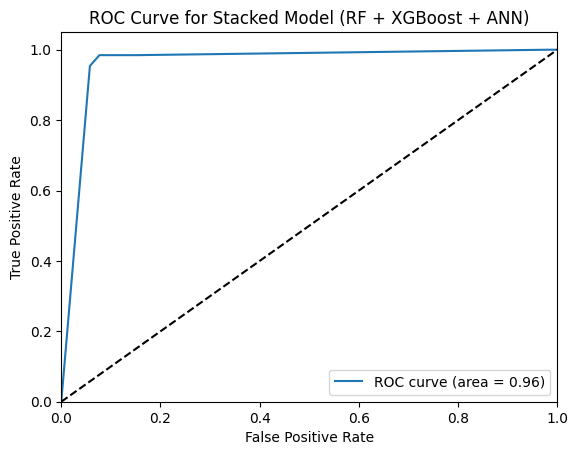

In [ ]:
# prompt: roc curve for the stacked model with model name

from sklearn.metrics import roc_curve, auc

# Assuming 'meta_model', 'meta_features_test', and 'y_test' are defined from the previous code
y_pred_proba = meta_model.predict(meta_features_test).flatten()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacked Model (RF + XGBoost + ANN)')
plt.legend(loc="lower right")
plt.show()

# CNN

In [ ]:
# Reshape data for CNN input (batch_size, timesteps, features)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

In [ ]:
# Check and potentially convert X_train_cnn and X_test_cnn to the appropriate dtype
X_train_cnn = X_train_cnn.astype(np.float32)  # or np.float64 if necessary
X_test_cnn = X_test_cnn.astype(np.float32)  # or np.float64 if necessary

In [ ]:
#Check and potentially convert target varibles to the appropriate dtype
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
# Build the CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # For binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=2)

Epoch 1/50
16/16 - 3s - 192ms/step - accuracy: 0.5300 - loss: 1.1423 - val_accuracy: 0.4615 - val_loss: 0.7553
Epoch 2/50
16/16 - 0s - 19ms/step - accuracy: 0.5180 - loss: 0.9374 - val_accuracy: 0.5299 - val_loss: 0.6934
Epoch 3/50
16/16 - 0s - 10ms/step - accuracy: 0.5080 - loss: 0.8469 - val_accuracy: 0.4701 - val_loss: 0.6922
Epoch 4/50
16/16 - 0s - 19ms/step - accuracy: 0.5300 - loss: 0.7577 - val_accuracy: 0.5983 - val_loss: 0.6853
Epoch 5/50
16/16 - 0s - 19ms/step - accuracy: 0.5080 - loss: 0.7360 - val_accuracy: 0.5470 - val_loss: 0.6882
Epoch 6/50
16/16 - 0s - 19ms/step - accuracy: 0.5140 - loss: 0.7041 - val_accuracy: 0.7863 - val_loss: 0.6848
Epoch 7/50
16/16 - 0s - 18ms/step - accuracy: 0.5200 - loss: 0.7306 - val_accuracy: 0.8034 - val_loss: 0.6858
Epoch 8/50
16/16 - 0s - 10ms/step - accuracy: 0.5600 - loss: 0.6892 - val_accuracy: 0.7265 - val_loss: 0.6827
Epoch 9/50
16/16 - 0s - 8ms/step - accuracy: 0.5180 - loss: 0.7178 - val_accuracy: 0.6923 - val_loss: 0.6663
Epoch 10/5

In [ ]:
# prompt: show the  accuracy, precision, f1-score recall of my cnn model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'cnn_model' and 'X_test_cnn' are defined from the previous code
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

print(f"CNN Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN Model Performance:
Accuracy: 0.9658119658119658
Precision: 0.9841269841269841
Recall: 0.9538461538461539
F1-score: 0.96875


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


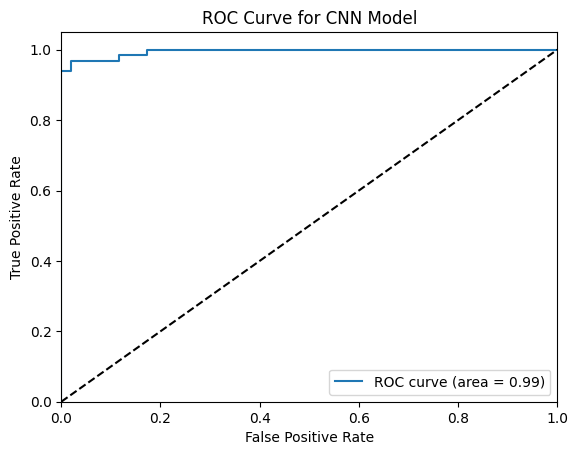

In [ ]:
# prompt: roc curve for the cnn model with model name

from sklearn.metrics import roc_curve, auc

# Assuming 'cnn_model' and 'X_test_cnn' are defined from the previous code
y_pred_proba = cnn_model.predict(X_test_cnn).flatten()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()

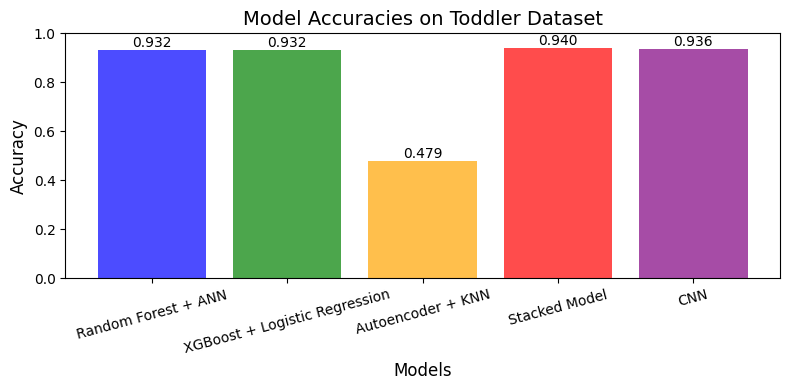

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values and model names
models = ['Random Forest + ANN', 'XGBoost + Logistic Regression', 'Autoencoder + KNN', 'Stacked Model', 'CNN']
accuracies = [0.931624, 0.931624, 0.478632, 0.940171, 0.936170]

# Plot the bar graph
plt.figure(figsize=(8, 4))  # Smaller figure size
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)

# Annotate accuracy values above bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title('Model Accuracies on Toddler Dataset', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=15, fontsize=10)
plt.ylim(0, 1)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

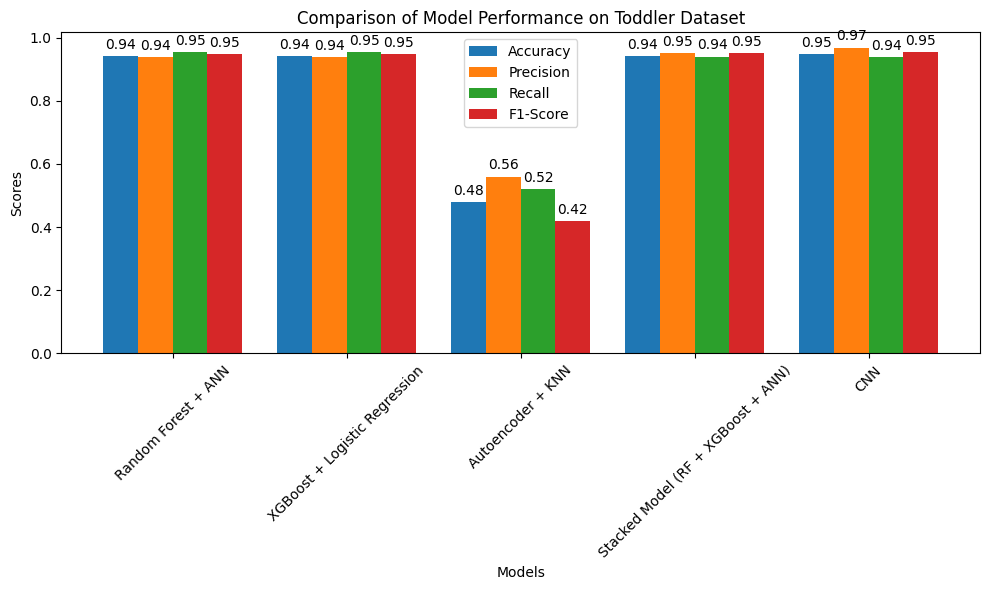

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for models
models = ['Random Forest + ANN', 'XGBoost + Logistic Regression', 'Autoencoder + KNN',
          'Stacked Model (RF + XGBoost + ANN)', 'CNN']
accuracy = [0.940171, 0.940171, 0.47863247863247865, 0.940170940170940, 0.9487179487179487]
precision = [0.939394, 0.939394, 0.56, 0.95, 0.9682539682539683]
recall = [0.953846, 0.953846, 0.52, 0.94, 0.9384615384615385]
f1_score = [0.946565, 0.946565, 0.42, 0.95, 0.953125]

# Set positions for bars
x = np.arange(len(models))  # Label locations
width = 0.2  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-Score')

# Add labels, title and customize axes
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance on Toddler Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Display the score values on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

# Show plot
fig.tight_layout()
plt.show()
